<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"></ul></div>

In [2]:
push!(LOAD_PATH, ".")
using RobustOptimization
using Ipopt, JuMP, PyPlot
using ScikitLearn
@sk_import model_selection: train_test_split
@sk_import metrics: roc_curve
@sk_import metrics: roc_auc_score
path_train = "datasets/diabetes_scale"
nbfeatures = 8
data_train = read_data_libsvm(path_train, nbfeatures);
xtr, xte, ytr, yte = train_test_split(data_train[:,1:end-1], data_train[:,end], train_size = 0.15)
ab_train = hcat(xtr, ytr)
aux_train = ab_train[ab_train[:,end] .< 0,:]
ll_train = vcat(aux_train,data_train[data_train[:,end].>0,:])

xtr, xte, ytr, yte = train_test_split(ll_train[:,1:end-1], ll_train[:,end], train_size = 0.6)
df_train = hcat(xtr, ytr)
df_aux= hcat(xte, yte);

In [3]:
# df_train, df_aux = create_data("diabetes_scale", nbfeatures, 0.2, train_test_split)
solver = IpoptSolver(print_level = 2)
N = size(df_train)[1]
ϵ = 0.05
verbosity = 50
itmax = 2000
sample = 100

ambiguity = "entropic"
robustModel = RobustModel(N, nbfeatures, ϵ, ambiguity, LogisticRegression())
α = 1/norm(robustModel.descent_direction)
# α = 0.1
projParams = ProjParams(Int(40), 1e-5, sample, para_proj=Sequential(), para_inter=Sequential())
optParams = OptParams(itmax, 1e-5, α, verbosity = verbosity);

In [3]:
# Séparer à la main entre label 1 et 0 et regarder les fréquences de chacun
# Fraude bancaire avec faux positifs
# Avec erreur de 0.01% changer le label. Mislabelled training dataset (regarder papier sur le sujet)

In [4]:
xnormal = normal_opt(df_train, solver, robustModel.regressionModel)
fpr, tpr, thresholds = roc_curve(df_aux[:,end], positive_rate(xnormal,df_aux))


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************



([0.0, 0.0, 0.0666667, 0.0666667, 0.133333, 0.133333, 0.2, 0.2, 0.266667, 0.266667  …  0.4, 0.533333, 0.533333, 0.6, 0.6, 0.733333, 0.733333, 0.8, 0.8, 1.0], [0.005, 0.24, 0.24, 0.475, 0.475, 0.57, 0.57, 0.63, 0.63, 0.72  …  0.94, 0.94, 0.955, 0.955, 0.985, 0.985, 0.995, 0.995, 1.0, 1.0], [0.999923, 0.996079, 0.996071, 0.98923, 0.989166, 0.98439, 0.984186, 0.978468, 0.978027, 0.968607  …  0.78263, 0.755935, 0.680138, 0.675409, 0.563336, 0.518746, 0.492958, 0.44875, 0.392565, 0.0698507])

In [5]:
dm_tab = []
xr1_tab = []
xr2_tab = []
fpr1_tab = []
tpr1_tab = []
fpr2_tab = []
tpr2_tab = []
for ϵ in [0.001,0.005,0.01,0.05,0.1,0.5,1.0]
    println(" ")
    println("espilon = ", ϵ)
    println(" ")
    robustModel = RobustModel(N, nbfeatures, ϵ, ambiguity, LogisticRegression())
    x0 = initialize(df_train, robustModel, EntropicConstraint())
    xalg, yalg, dm, mem, mini = run_algo(x0, df_train, robustModel, optParams, projParams)
    xrobust1 = getsolution(xalg, ambiguity, nbfeatures)
    xrobust2 = getsolution(mem, ambiguity, nbfeatures)
    fpr1, tpr1, thresholds = roc_curve(df_aux[:,end], positive_rate(xrobust1,df_aux))
    fpr2, tpr2, thresholds = roc_curve(df_aux[:,end], positive_rate(xrobust2,df_aux))
    push!(dm_tab, dm)
    push!(xr1_tab, xrobust1)
    push!(xr2_tab, xrobust2)
    push!(fpr1_tab, fpr1)
    push!(tpr1_tab, tpr1)
    push!(fpr2_tab, fpr2)
    push!(tpr2_tab, tpr2)
end

 
espilon = 0.001
 
50 0.027695928753505905 100 0.01608861023182495 150 0.022990511652669632 200 0.02568986473200363 250 0.003982152630545455 300 0.08002972115447182 350 0.02181513175336347 400 0.008512393843736477 450 0.010697107008812434 500 0.04093755111633968 550 0.005952381077871549 600 0.0025696426678738504 650 0.04318666960082673 700 0.07741748434456763 750 0.0716169688441255 800 0.08339133688413725 850 0.037929816625378976 900 0.009591085187300008 950 0.03252381743421573 1000 0.010154443177293526 1050 0.06176617369929538 1100 0.00898050848682641 1150 0.019074994187964656 1200 0.08273091593848303 1250 0.013528533470824833 1300 0.04327993403548014 1350 0.010320052723931328 1400 0.0017622063679976069 1450 0.005941146464484959 1500 0.020474517086998878 1550 0.06205170268600213 1600 0.04071895145110638 1650 0.05081919809257407 1700 0.05203377284887711 1750 0.009695696461167636 1800 0.0022432054683787506 1850 0.05247852201568026 1900 0.003896477594079184 1950 0.007707021170994199 200

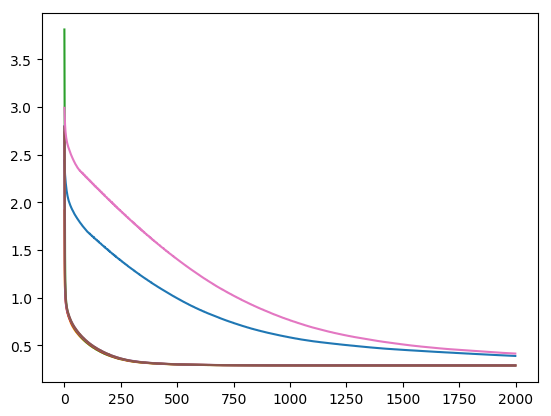

In [6]:
for i in 1:7
     plot(dm_tab[i])
end

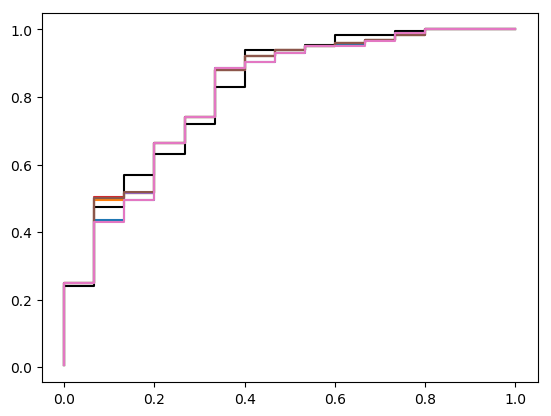

In [7]:
plot(fpr,tpr, color="black")
for i in 1:7
     plot(fpr1_tab[i], tpr1_tab[i])
end

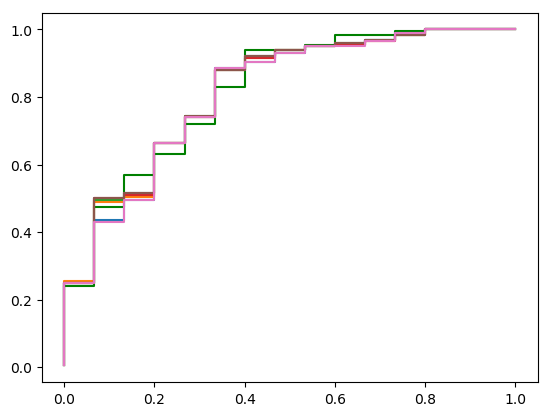

In [8]:
plot(fpr,tpr, color="green")
for i in 1:7
     plot(fpr2_tab[i], tpr2_tab[i])
end

In [9]:
println(roc_auc_score(df_aux[:,end], positive_rate(xnormal,df_aux)))
for i in 1:7
    println(roc_auc_score(df_aux[:,end], positive_rate(xr1_tab[i],df_aux)))
end

0.8176666666666667
0.8113333333333332
0.8180000000000001
0.8183333333333334
0.8186666666666667
0.8183333333333334
0.8186666666666667
0.8103333333333333


In [10]:
println(roc_auc_score(df_aux[:,end], positive_rate(xnormal,df_aux)))
for i in 1:7
    println(roc_auc_score(df_aux[:,end],positive_rate(xr2_tab[i],df_aux)))
end

0.8176666666666667
0.8113333333333332
0.8163333333333334
0.8183333333333334
0.817
0.8183333333333334
0.8186666666666667
0.8103333333333333


In [ ]:
# @everywhere df_train, df_aux = create_data("diabetes_scale", nbfeatures, 0.7, train_test_split)
# @everywhere solver = IpoptSolver(print_level = 2)
N = size(df_train)[1]
# @everywhere ϵ = 0.05
verbosity = 1
itmax = 500
sample = 128

ambiguity = "wasserstein"
robustModel = RobustModel(N, nbfeatures, ϵ, ambiguity, LogisticRegression())
α = 1/norm(robustModel.descent_direction)
# @everywhere α = 1.0
projParams = ProjParams(Int(1000), 1e-5, sample, para_proj=Sequential(), para_inter=Sequential())
optParams = OptParams(itmax, 1e-5, α, verbosity = verbosity);

In [ ]:
xnormal = normal_opt(df_train, solver, robustModel.regressionModel)
fpr, tpr, thresholds = roc_curve(df_aux[:,end], positive_rate(xnormal,df_aux))

In [ ]:
dm_was = []
xr1_was = []
xr2_was = []
fpr1_was = []
tpr1_was = []
fpr2_was = []
tpr2_was = []
for ϵ in [0.001,0.005,0.01,0.05,0.1,0.5,1.0]
# for ϵ in [0.001,0.005,0.01]
    println(" ")
    println("espilon = ", ϵ)
    println(" ")
    robustModel = RobustModel(N, nbfeatures, ϵ, ambiguity, LogisticRegression())
    x0 = init_proj(df_train, robustModel, projParams);
    xalg, yalg, dm, mem, mini = run_algo(x0, df_train, robustModel, optParams, projParams)
    xrobust1 = getsolution(xalg, ambiguity, nbfeatures)
    xrobust2 = getsolution(mem, ambiguity, nbfeatures)
    fpr1, tpr1, thresholds = roc_curve(df_aux[:,end], positive_rate(xrobust1,df_aux))
    fpr2, tpr2, thresholds = roc_curve(df_aux[:,end], positive_rate(xrobust2,df_aux))
    push!(dm_was, dm)
    push!(xr1_was, xrobust1)
    push!(xr2_was, xrobust2)
    push!(fpr1_was, fpr1)
    push!(tpr1_was, tpr1)
    push!(fpr2_was, fpr2)
    push!(tpr2_was, tpr2)
end

In [ ]:
for i in 1:7
     plot(dm_was[i])
end

In [ ]:
plot(fpr,tpr, color="green")
for i in 1:7
     plot(fpr1_was[i], tpr1_was[i])
end

In [ ]:
plot(fpr,tpr, color="green")
for i in 1:7
     plot(fpr2_was[i], tpr2_was[i])
end

In [ ]:
# Montrer pour différente de taille de dataset et regarder à partir de quel moment la méthode de base décroche

In [ ]:
println(roc_auc_score(df_aux[:,end], positive_rate(xnormal,df_aux)))
for i in 1:7
    println(roc_auc_score(df_aux[:,end],positive_rate(xr1_was[i],df_aux)))
end

In [ ]:
println(roc_auc_score(df_aux[:,end], positive_rate(xnormal,df_aux)))
for i in 1:7
    println(roc_auc_score(df_aux[:,end],positive_rate(xr2_was[i],df_aux)))
end